In [63]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F

In [79]:
from data import SeqDataLoader
from data import LoadTimeMachine


def dataloader(file_path, batch_size, num_steps, use_random_iter=False, token='word', min_freq=0,
               reserved_tokens=None):
    data_ = LoadTimeMachine(file_path=file_path, token=token, min_freq=min_freq, reserved_tokens=reserved_tokens)
    vocab_ = data_.get_vocab()

    dataloader_ = SeqDataLoader(data=data_, batch_size=batch_size, num_steps=num_steps, use_random_iter=use_random_iter)
    del data_

    return dataloader_, vocab_


file_path = 'the-time-machine.txt'
# 加载数据迭代器 和 词表
batch_size, num_steps = 32, 35
train_iter, vocab = dataloader(file_path=file_path, batch_size=batch_size, num_steps=num_steps)

独热编码

简言之，将每个索引映射为相互不同的单位向量： 假设词表中不同词元的数目为（即len(vocab)），词元索引的范围为 0 到 N - 1 。如果词元的索引是整数，那么我们将创建一个长度为 N 的全 0 向量，并将第 i 处的元素设置为 1 。

In [80]:
for X, y in train_iter:
    print("X: {}\n".format(X.shape), X)
    print("y: {}\n".format(y.shape), y)
    break
# 每个都是一个 [32, 35] 的张量，每一行 [35, ] 都是一句话，每个数字代表一个 token

X: torch.Size([32, 35])
 tensor([[ 176,   43, 1566,  ...,   68,   26,  548],
        [   2,  310,  196,  ...,    2,  170,   49],
        [  49,   12,   27,  ...,    2,   20,   86],
        ...,
        [   1,  349,  179,  ...,   17,    1,  156],
        [5257,  174,   55,  ...,   84,  229,  381],
        [ 328,  217,    1,  ...,  421, 2465, 1135]])
y: torch.Size([32, 35])
 tensor([[  43, 1566, 1567,  ...,   26,  548,    7],
        [ 310,  196,   49,  ...,  170,   49,  159],
        [  12,   27, 2710,  ...,   20,   86, 2714],
        ...,
        [ 349,  179,    3,  ...,    1,  156,   45],
        [ 174,   55,   82,  ...,  229,  381,    7],
        [ 217,    1, 1140,  ..., 2465, 1135,   19]])


In [81]:
# 独热编码案例
F.one_hot(torch.tensor([0, 2]), 10), F.one_hot(torch.tensor([0, 2]), 10).shape
# 将 [0, 2] 转变为长为 10 的独热编码，即第 0 位置为 1 其他为 0 ，以及第 2 位置为 1 其他为 0 

(tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]),
 torch.Size([2, 10]))

In [82]:
tmp = torch.zeros((32, 35))
print(tmp.shape)
tmp = F.one_hot(tmp.T.long(), len(vocab))  # one_hot 只对整数类型，且在最后一个维度扩展
print(tmp.shape)

torch.Size([32, 35])
torch.Size([35, 32, 5471])


初始化模型参数

In [83]:
def get_params(vocab_size, num_hiddens, device):
    """
    获取参数
    :param vocab_size: 词汇表的大小，即输入和输出的维度
    :param num_hiddens: 隐藏层的大小，即隐藏状态的维度
    :param device: 指定参数存储在 CPU 还是 GPU 上
    :return: 需要学习的参数 
    """
    num_inputs = num_outputs = vocab_size  # 特征数，也是输入输出数，即词汇表的大小

    # num_inputs, num_outputs 只是在这个例子里等于 vocab_size

    def normal(shape):
        """
        均值为 0、标准差为 0.01 的随机值
        :param shape: 形状 
        :return: 参数 (均值为 0、标准差为 0.01 的随机张量)
        """
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)

    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    # 参数
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

从零实现 整合版本

In [ ]:
import os.path
import time
import torch

from torch import nn


class BasicModule(nn.Module):
    """
    作为基类，继承 nn.Module 但增加了模型保存和加载功能 save and load
    """

    def __init__(self):
        super().__init__()
        self.model_name = str(type(self))

    def load(self, model_path):
        """
        根据模型路径加载模型
        :param model_path: 模型路径
        :return: 模型
        """
        self.load_state_dict(torch.load(model_path))

    def save(self, filename=None):
        """
        保存模型，默认使用 "模型名字 + 时间" 作为文件名，也可以自定义
        如 ResNet34_20250710_23:57:29.pth
        """
        if filename is None:
            filename = self.model_name + '_' + time.strftime("%Y-%m-%d-%H-%M-%S") + '.pth'
        torch.save(self.state_dict(), os.path.join('checkpoints', filename))
        return filename

In [84]:
class RNNModelScratch:
    """从零开始实现的循环神经网络模型"""

    def __init__(self, vocab_size, num_hiddens, device):
        """初始化"""

        # 词典长度 (特征数/不同 token 的个数)
        self.vocab_size = vocab_size
        # 隐藏单元数
        self.num_hiddens = num_hiddens

        # 获取参数
        self.params = self._get_params(vocab_size, num_hiddens, device)

    def __call__(self, X, state):
        """call 方法，可以以函数的方法使用实例化对象"""
        X = F.one_hot(X.T.long(), self.vocab_size).type(torch.float32)
        return self._forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        """起始隐藏层状态 state
        :param batch_size: 批量大小
        :param device: 设备
        :return 起始隐藏层状态 H.shape = (batch_size, num_hiddens)
        """
        return (torch.zeros((batch_size, self.num_hiddens), device=device),)

    def _get_params(self, vocab_size, num_hiddens, device):
        """
        获取参数
        :param vocab_size: 词汇表的大小，即输入和输出的维度
        :param num_hiddens: 隐藏层的大小，即隐藏状态的维度
        :param device: 指定参数存储在 CPU 还是 GPU 上
        :return: 需要学习的参数 
        """
        # num_inputs, num_outputs 只是在这个例子里等于 vocab_size
        num_inputs = num_outputs = vocab_size  # 特征数，也是输入输出数，即词汇表的大小

        def normal(shape):
            """
            均值为 0、标准差为 0.01 的随机值
            :param shape: 形状 
            :return: 参数 (均值为 0、标准差为 0.01 的随机张量)
            """
            return torch.randn(size=shape, device=device) * 0.01

        # 隐藏层参数
        W_xh = normal((num_inputs, num_hiddens))
        W_hh = normal((num_hiddens, num_hiddens))
        b_h = torch.zeros(num_hiddens, device=device)

        # 输出层参数
        W_hq = normal((num_hiddens, num_outputs))
        b_q = torch.zeros(num_outputs, device=device)

        # 参数
        params = [W_xh, W_hh, b_h, W_hq, b_q]
        for param in params:
            param.requires_grad_(True)
        return params

    def _forward_fn(self, inputs, state, params):
        """前向传播
        :param inputs: 输入 X
        :param state: 隐藏状态 H
        :param params: 模型可学习参数
        """
        # inputs的形状：(时间步数量，批量大小，词表大小)
        W_xh, W_hh, b_h, W_hq, b_q = params
        H, = state

        outputs = []
        for X in inputs:  # X的形状：(批量大小，词表大小)
            H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
            Y = torch.mm(H, W_hq) + b_q
            outputs.append(Y)
        # 返回输出和隐藏状态: O, (H, ) 
        return torch.cat(outputs, dim=0), (H,)

In [85]:
def try_gpu():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [86]:
""" 测试 """

# 隐藏层单元数/维度
num_hiddens = 512

# 实例化网络
net = RNNModelScratch(
    vocab_size=len(vocab),
    num_hiddens=num_hiddens,
    device=try_gpu()
)

# 模拟一个输入 X
X = torch.rand((32, 35))

# 初始状态
state = net.begin_state(X.shape[0], try_gpu())

# 输出和新状态
Y, new_state = net(X.to(try_gpu()), state)

# 输出结果
print("Y shape: {}".format(Y.shape))  # Y shape (batch_size * num_steps, vocab_size) = (32 * 35, 5471)
print("new state shape: {}".format(new_state[0].shape))  # 仍然为 (batch_size, num_hiddens)

Y shape: torch.Size([1120, 5471])
new state shape: torch.Size([32, 512])


预测

In [91]:
def predict(prefix, num_preds, net, vocab, device, token='word'):
    """
    在 prefix 后面生成新字符
    :param prefix: 用户输入的前文
    :param num_preds: 向后预测几个时间步
    :param net: RNN 网络
    :param vocab: 词表，传入 token 获得索引
    :param device: 设备
    :return: 词表转文本字符串
    """
    # 起始隐藏状态
    state = net.begin_state(batch_size=1, device=device)

    # 先把 prefix 第一个 token 转为数字索引存入 outputs
    outputs = [vocab[prefix[0]]]

    def get_input():
        """
        根据 outputs 列表中的最后一个元素生成新的输入张量
        :param outputs: 已经输出的列表
        :param device : 设备
        :return torch.Tensor: 形状为 (1, 1) 的张量，作为下一个时间步的输入
        """
        # 获取 outputs 列表中的最后一个元素
        last_output = outputs[-1]
        # 将其转换为张量，并存储在指定设备上
        input_tensor = torch.tensor([last_output], device=device)
        # 调整张量的形状为 (1, 1)
        return input_tensor.reshape((1, 1))

    # 1. 预热期
    for y in prefix[1:]:
        # 为了得到 prefix 对应的状态 state
        # 输入已经输出的最后一步，得到新的 state (此时没有在预测，仍然是 prefix 的已知元素)
        _, state = net(get_input(), state)
        # 加入 outputs 列表，然后后移
        outputs.append(vocab[y])

    # 2. 开始预测
    for _ in range(num_preds):  # 预测 num_preds 步
        y, state = net(get_input(), state)

        # 获取概率最高的下标
        outputs.append(int(y.argmax(dim=1).reshape(1)))

    # 按照词表转换为字符输出
    if token == 'word':
        # 按照单词
        return ' '.join([vocab.idx_to_token[i] for i in outputs])
    else:
        # 按照逐个字母
        return ''.join([vocab.idx_to_token[i] for i in outputs])

In [92]:
prefix = 'time traveller '
prefix = prefix.split()  # 注意此处为按照 word 切割
print(predict(prefix=prefix, num_preds=10, net=net, vocab=vocab, device=try_gpu()))

time traveller previous version experience motion breach delicateminded amuse hopelessly went determines”


梯度裁剪

In [93]:
def grad_clipping(net, theta):
    """裁剪梯度
    :param net: 网络
    :param theta: 判断半径
    """
    # 检查是否采样高级 API 如 PyTorch 提供的 nn.Module 类
    if isinstance(net, nn.Module):
        # 属于 nn.Module 类，则 params 从模型中提取可被学习的
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        # 属于手动创建的网络，全部都是可学习的
        params = net.params

    # 获取所有参数的梯度的模长和
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        # 如果梯度太大，则缩小
        for param in params:
            param.grad[:] *= theta / norm

训练

In [94]:
import time


class Accumulator:
    """用于累加多个值的工具类"""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def __getitem__(self, idx):
        return self.data[idx]


class Timer:
    """计时器类"""

    def __init__(self):
        self.start_time = time.time()

    def stop(self):
        return time.time() - self.start_time

In [95]:
def train_one_epoch(net, train_iter, loss, updater, device, use_random_iter=False):
    """训练网络一个迭代周期"""
    state = None  # 初始化隐藏状态为 None
    timer = Timer()  # 创建一个计时器，用于计算训练时间
    metric = Accumulator(2)  # 创建一个累加器，用于记录 "训练损失" 和 "词元数量" -> 2 表示累加器有两个槽位

    for X, Y in train_iter:
        if state is None or use_random_iter == True:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state 对于 nn.GRU 是个张量
                state.detach_()
            else:
                # state 对于 nn.LSTM 或对于从零开始实现的模型是个张量
                for s in state:
                    s.detach_()

        y = Y.T.reshape(-1)  # 将标签 Y 转置并 ==展平== 为一维张量
        X, y = X.to(device), y.to(device)

        y_hat, state = net(X, state)  # 前向传播，获取输出 y_hat 和更新后的隐藏状态 state
        l = loss(y_hat, y.long()).mean()  # 计算损失，并取平均值

        if isinstance(updater, torch.optim.Optimizer):
            # 如果为 PyTorch 的高级优化器
            updater.zero_grad()  # 梯度清零
            l.backward()  # 反向传播
            grad_clipping(net=net, theta=1)  # 梯度裁剪
            updater.step()  # 更新参数
        else:
            l.backward()
            grad_clipping(net=net, theta=1)  # 梯度裁剪
            updater(batch_size=1)  # 自定义更新器

        metric.add(l * y.numel(), y.numel())  # 累加 "损失" 和 "词元数量" (numel 返回张量所有元素个数，即维度乘积)
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()  # 返回 "困惑度" 和 "训练速度"

In [96]:
def sgd(params, lr, batch_size):
    """
    自定义的 SGD 更新器。
    参数:
        params (list): 模型参数的列表。
        lr (float): 学习率。
        batch_size (int): 批量大小。
    """
    with torch.no_grad():  # 不需要计算梯度
        for param in params:
            if param.grad is not None:
                param -= lr * param.grad / batch_size  # 更新参数
                param.grad.zero_()  # 梯度清零

In [102]:
from matplotlib import pyplot as plt
from IPython.display import clear_output


class Animator:
    def __init__(self, xlabel, ylabel, legend, xlim):
        """
        初始化动态可视化工具。

        参数:
            xlabel (str): x 轴标签。
            ylabel (str): y 轴标签。
            legend (list): 图例列表。
            xlim (list): x 轴范围。
        """
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.legend = legend
        self.xlim = xlim
        self.x_data = []
        self.y_data = []

    def add(self, x, y):
        """
        添加数据点。

        参数:
            x (float): x 轴值。
            y (float): y 轴值。
        """
        self.x_data.append(x)
        self.y_data.append(y)

    def plot(self):
        """绘制当前数据点并显示图像"""
        clear_output(wait=True)  # 清除之前的输出
        plt.figure(figsize=(8, 4))  # 设置图像大小
        plt.plot(self.x_data, self.y_data, label=self.legend[0])  # 绘制曲线
        plt.xlabel(self.xlabel)  # 设置 x 轴标签
        plt.ylabel(self.ylabel)  # 设置 y 轴标签
        plt.xlim(self.xlim)  # 设置 x 轴范围
        plt.legend()  # 显示图例
        plt.grid(True)  # 显示网格
        plt.show()  # 显示图像

In [115]:
def train(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    """
    完整训练
    :param net: 神经网络类
    :param train_iter: 数据迭代器
    :param vocab: 词表
    :param lr: 学习率
    :param num_epochs: 迭代次数
    :param device: 设备
    :param use_random_iter: 是否随机抽样 
    """

    loss = nn.CrossEntropyLoss()
    ppl_list = []
    # vis = Animator(xlabel='epoch', ylabel='perplexity', legend=['train'], xlim=[10, num_epochs])

    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        def updater(batch_size):  # 传入 train_one_epoch
            return sgd(net.params, lr, batch_size)

    ppl = 0.
    speed = 0.
    # 训练
    for epoch in range(num_epochs):
        ppl, speed = train_one_epoch(net, train_iter, loss, updater, device, use_random_iter)
        ppl_list.append(ppl)
        
        if num_epochs < 100:
            print("= {} / {} 困惑度 {:.1f} | {:.1f} 词元/秒 = ".format(epoch + 1, num_epochs, ppl, speed))
        else:
            if (epoch + 1) % 10 == 0:
                print("= {} / {} 困惑度 {:.1f} | {:.1f} 词元/秒 = ".format(epoch + 1, num_epochs, ppl, speed))
                # vis.add(epoch + 1, [ppl])  # 动态展示/添加
    print("[困惑度 {:.1f} | {:.1f} 词元/秒 on {}]".format(ppl, speed, str(device)))
    # vis.plot()
    return ppl_list

In [116]:
# 正式训练
from data import SeqDataLoader
from data import LoadTimeMachine

token = 'char'


def dataloader(file_path, batch_size, num_steps, use_random_iter=False, token=token, min_freq=0,
               reserved_tokens=None):
    data_ = LoadTimeMachine(file_path=file_path, token=token, min_freq=min_freq, reserved_tokens=reserved_tokens)
    vocab_ = data_.get_vocab()

    dataloader_ = SeqDataLoader(data=data_, batch_size=batch_size, num_steps=num_steps, use_random_iter=use_random_iter)
    del data_

    return dataloader_, vocab_


file_path = 'the-time-machine.txt'
# 加载数据迭代器 和 词表
batch_size, num_steps = 32, 35
train_iter, vocab = dataloader(file_path=file_path, batch_size=batch_size, num_steps=num_steps)

# 实例化网络
net = RNNModelScratch(
    vocab_size=len(vocab),
    num_hiddens=num_hiddens,
    device=try_gpu()
)

num_epochs, lr = 10, 1
ppl_list = train(net, train_iter, vocab, lr, num_epochs, try_gpu())

# 预测
prefix = 'time traveller '
# prefix = prefix.split()
print(predict(prefix=prefix, num_preds=25, net=net, vocab=vocab, device=try_gpu(), token=token))

= 1 / 10 困惑度 16.4 | 17077.8 词元/秒 = 
= 2 / 10 困惑度 11.0 | 11004.6 词元/秒 = 
= 3 / 10 困惑度 10.0 | 11255.4 词元/秒 = 
= 4 / 10 困惑度 9.5 | 11654.5 词元/秒 = 
= 5 / 10 困惑度 9.0 | 13432.2 词元/秒 = 
= 6 / 10 困惑度 8.6 | 11147.9 词元/秒 = 
= 7 / 10 困惑度 8.2 | 11382.1 词元/秒 = 
= 8 / 10 困惑度 7.9 | 11327.8 词元/秒 = 
= 9 / 10 困惑度 7.7 | 11485.9 词元/秒 = 
= 10 / 10 困惑度 7.4 | 11441.0 词元/秒 = 
[困惑度 7.4 | 11441.0 词元/秒 on cpu]
time traveller and the mare a ditere the


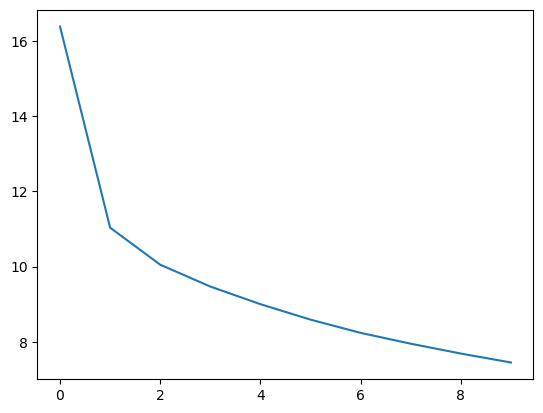

In [117]:
plt.plot(ppl_list)
plt.show()